In [31]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
title_size = 24
axis_label_size = 24
tick_label_size = 22
legend_size = 22

# Paleta de colores única
palette = ["#28ABB9", "#F18D35", "#4CB944", "#E63946"]  # Blue, Orange, Green, Red
linewidth = 2.5
filter_window = 20

In [33]:
def scale_usage(df, column_name, scale_factor):
    """Escala el consumo del total a una sola unidad (CPU/GPU)."""
    df[column_name] = df[column_name] * scale_factor
    return df

df = pd.read_csv("/export/usuarios_ml4ds/lbartolome/Repos/my_repos/UserInLoopHTM/checkcpu_baseline.csv",
                 header=None, names=["cpu"]).dropna()
df["cpu"] = df["cpu"].apply(lambda x: float(x.split("%")[0]))
df = scale_usage(df, "cpu", 96)
baseline = df["cpu"].mean()
baseline

194.64718817136355

In [34]:
def scale_usage(df, column_name, scale_factor):
    """Escala el consumo del total a una sola unidad (CPU/GPU)."""
    df[column_name] = df[column_name] * scale_factor
    return df

def load_and_truncate_cpu(files, column_name, execution_times, window, scale_factor=1):
    all_iterations = []

    df = pd.read_csv("/export/usuarios_ml4ds/lbartolome/Repos/my_repos/UserInLoopHTM/checkcpu_baseline.csv",
                 header=None, names=["cpu"]).dropna()
    df["cpu"] = df["cpu"].apply(lambda x: float(x.split("%")[0]))
    df = scale_usage(df, "cpu", 96)
    baseline = df["cpu"].mean()

    for i, file in enumerate(files):
        if i < len(execution_times):
            exec_time = execution_times.loc[i, "execution_time"]
            df = pd.read_csv(file, header=None, names=[column_name]).dropna()
            df[column_name] = df[column_name].apply(lambda x: float(x.split("%")[0]))

            # Crear columna `time_instant` en función del tiempo de ejecución real
            df["time_instant"] = (df.index / len(df)) * exec_time

            # Asegurarse de que `time_instant` es único para interpolar
            grouped_df = df.groupby("time_instant").mean().reset_index()

            # Interpolar valores en un rango temporal común
            time_range = np.arange(0, exec_time + 1)  # Rango desde 0 hasta `exec_time` en pasos de 1s
            interpolated_df = pd.DataFrame({
                "time_instant": time_range,
                column_name: np.interp(
                    time_range,
                    grouped_df["time_instant"],
                    grouped_df[column_name],
                    left=0,
                    right=0,
                )
            })

            interpolated_df = scale_usage(interpolated_df, column_name, scale_factor)
            interpolated_df["cpu"] = interpolated_df["cpu"] - baseline

            all_iterations.append(interpolated_df)

    if all_iterations:
        # Concatenar todas las iteraciones alineadas en el mismo rango de tiempo
        combined = pd.concat(all_iterations).groupby("time_instant", as_index=False).mean()

        # Aplicar media móvil (rolling) para suavizar
        combined[column_name] = combined[column_name].rolling(window=window, min_periods=1).mean()

        execution_time_mean = (execution_times["execution_time"].iloc[:3] / 60) .mean()
        execution_time_var = (execution_times["execution_time"].iloc[:3]/ 60).var()
        
        return combined, execution_time_mean, execution_time_var

    return pd.DataFrame(columns=["time_instant", column_name]), None, None


def load_and_truncate_gpu(files, column_name, execution_times, window, num_gpus=3):
    """Carga, ajusta según tiempos de ejecución y calcula el promedio de consumo de GPU."""
    import numpy as np
    import pandas as pd

    all_iterations = []

    for i, file in enumerate(files):
        if i < len(execution_times):
            exec_time = execution_times.loc[i, "execution_time"]

            # Leer archivo y convertir los valores a porcentajes
            df = pd.read_csv(file, header=None, names=[column_name]).dropna()
            df[column_name] = df[column_name].apply(lambda x: float(x.split("%")[0]))

            # Agrupar por GPU IDs
            df["gpu_id"] = df.index % num_gpus
            df["time_instant"] = (df.index // num_gpus) / (len(df) // num_gpus) * exec_time

            # Asegurarse de que `time_instant` es único para interpolar
            grouped_df = df.groupby("time_instant").mean().reset_index()

            # Interpolar valores en un rango temporal común
            time_range = np.arange(0, exec_time + 1)  # Rango desde 0 hasta `exec_time` en pasos de 1s
            interpolated_df = pd.DataFrame({
                "time_instant": time_range,
                column_name: np.interp(
                    time_range,
                    grouped_df["time_instant"],
                    grouped_df[column_name],
                    left=0,
                    right=0,
                )
            })

            all_iterations.append(interpolated_df)

    if all_iterations:
        # Concatenar todas las iteraciones alineadas en el mismo rango de tiempo
        combined = pd.concat(all_iterations).groupby("time_instant", as_index=False).mean()

        # Aplicar media móvil (rolling) para suavizar
        combined[column_name] = combined[column_name].rolling(window=window, min_periods=1).mean()
        execution_time_mean = (execution_times["execution_time"].iloc[:3] / 60) .mean()
        execution_time_var = (execution_times["execution_time"].iloc[:3]/ 60).var()        
        return combined, execution_time_mean, execution_time_var

    return pd.DataFrame(columns=["time_instant", column_name]), None, None

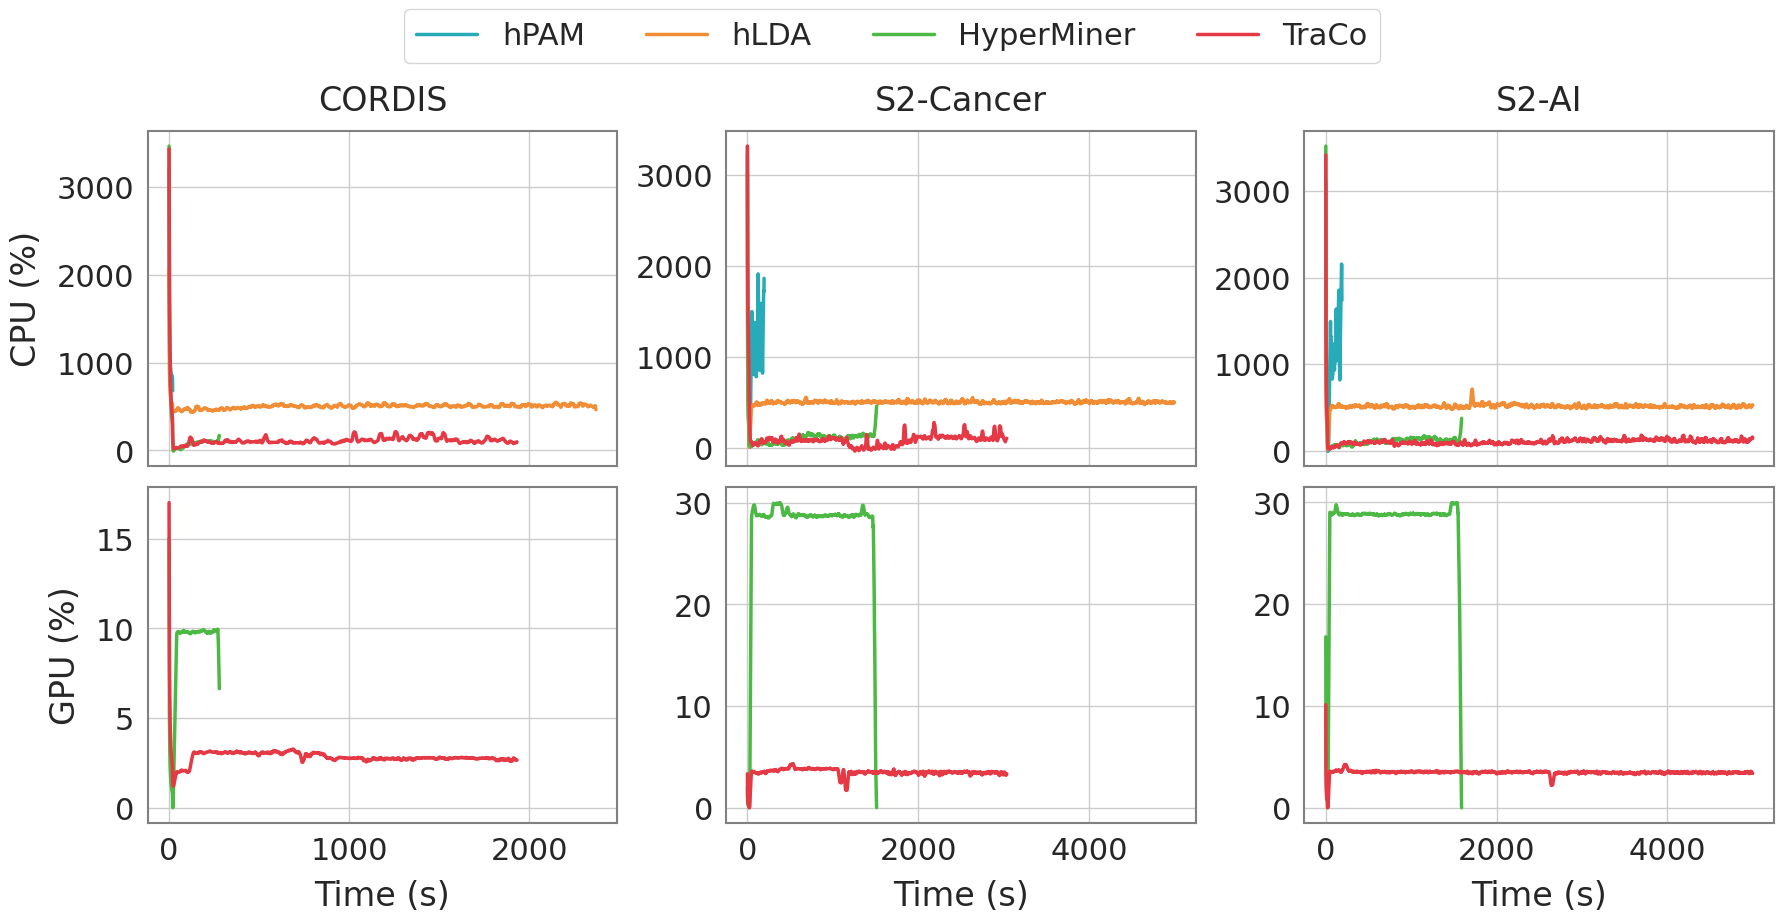

In [35]:
# Configuración del estilo y colores
sns.set_theme(style="whitegrid", rc={"axes.edgecolor": "gray", "axes.linewidth": 1.5})
linewidth = 2.5
filter_window = 20

# Procesar los datos
# Diccionario para mapear nombres de archivos a nombres bonitos
algorithm_names = {
    "hpam": "hPAM",
    "hlda": "hLDA",
    "hyperminer": "HyperMiner",
    "traco": "TraCo"
}
datset_names = {
    "cordis": "CORDIS",
    "cancer": "S2-Cancer",
    "ai": "S2-AI"
}
# Procesar los datos
all_data = []
from collections import defaultdict
times = defaultdict(lambda: defaultdict(dict))
path_models1 = "/export/usuarios_ml4ds/lbartolome/Repos/my_repos/UserInLoopHTM/data/models_v3"
path_models2 =  "/export/usuarios_ml4ds/lbartolome/Repos/my_repos/UserInLoopHTM/data/models_v4_topmost"
algorithms = ["hpam", "hlda", "hyperminer", "traco"]  # Nombres en minúsculas para archivos
datasets = ["cordis", "cancer", "ai"]

for algo in algorithms:
    path_models = path_models2 if algo in ["traco", "hyperminer"] else path_models1
    for dtset in datasets:
        dtset_ = "s2cs-ai" if algo in ["traco", "hyperminer"] and dtset == "ai" else dtset
        exec_time_file = glob.glob(f"{path_models}/{algo}/{dtset_}/execution_times.csv")
        if exec_time_file:
            execution_times = pd.read_csv(exec_time_file[0])
            execution_times = execution_times.rename(columns={"Execution Time (s)": "execution_time"})
        else:
            continue

        cpu_files = glob.glob(f"{path_models}/{algo}/{dtset_}/cpu_usage_iter.*.csv")
        gpu_files = glob.glob(f"{path_models}/{algo}/{dtset_}/gpu_usage_iter.*.csv")
        df_cpu, mean_time, std_time = load_and_truncate_cpu(cpu_files, "cpu", execution_times, filter_window, scale_factor=96)
        df_gpu, _, _ = load_and_truncate_gpu(gpu_files, "gpu", execution_times, filter_window, num_gpus=3)
        
        df_combined = pd.merge(df_cpu, df_gpu, on="time_instant", how="outer").fillna(0)
        df_combined = df_combined.head(int(execution_times.execution_time.mean()))
        df_combined["algorithm"] = algorithm_names[algo]  # Usar nombres formateados
        df_combined["dataset"] = dtset
        all_data.append(df_combined)

        times[algo][dtset] = {
            "mean_time": mean_time,
            "std_time": std_time,
        }

usage_data = pd.concat(all_data, ignore_index=True)
usage_data.loc[usage_data["algorithm"] == "hLDA", "gpu"] = 0

times_df = pd.DataFrame([
    {"algorithm": algo, "dataset": ds, "mean_time": stats["mean_time"], "std_time": stats["std_time"]}
    for algo, datasets in times.items()
    for ds, stats in datasets.items()
])
times_df["algorithm"] = times_df["algorithm"].apply(lambda x: algorithm_names[x])

# Visualización mejorada
fig, axs = plt.subplots(2, len(datasets), figsize=(18, 9), sharex='col', sharey=False)  # Cambiar sharex a 'col'

for col, dataset in enumerate(datasets):
    subset = usage_data[usage_data["dataset"] == dataset]
    ax_cpu = axs[0, col]
    ax_gpu = axs[1, col]

    for i, algo in enumerate(algorithm_names.values()):
        algo_data = subset[subset["algorithm"] == algo]
        algo_data_zoom = algo_data[algo_data["time_instant"] <= 5000]
        
        # CPU (línea sólida)
        sns.lineplot(
            data=algo_data_zoom, x="time_instant", y="cpu", ax=ax_cpu, 
            color=palette[i], linewidth=linewidth, label=algo if col == 0 else None
        )
        
        # GPU (línea punteada) solo si el consumo no es 0
        if algo_data_zoom["gpu"].sum() > 0:  
            sns.lineplot(
                data=algo_data_zoom, x="time_instant", y="gpu", ax=ax_gpu, 
                color=palette[i], linewidth=linewidth, label=None
            )

    # Eliminar leyendas de los subgráficos
    if ax_cpu.get_legend() is not None:
        ax_cpu.get_legend().remove()
    if ax_gpu.get_legend() is not None:
        ax_gpu.get_legend().remove()

    # Mostrar etiquetas solo en la primera columna
    if col == 0:
        ax_cpu.set_ylabel("CPU (%)", fontsize=axis_label_size, labelpad=10)
        ax_gpu.set_ylabel("GPU (%)", fontsize=axis_label_size, labelpad=10)
    else:
        ax_cpu.set_ylabel("")
        ax_gpu.set_ylabel("")
    
    # Mostrar títulos solo en la primera fila
    if ax_cpu == axs[0, col]:
        ax_cpu.set_title(f"{datset_names[dataset]}", fontsize=title_size, pad=15)

    # Configuración del eje X
    ax_gpu.set_xlabel("Time (s)", fontsize=axis_label_size, labelpad=10)
    ax_cpu.tick_params(axis='both', labelsize=tick_label_size)
    ax_gpu.tick_params(axis='both', labelsize=tick_label_size)

# Leyenda global
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=4, fontsize=legend_size)

# Ajustes finales
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("images/revisions/cpu_gpu_usage_baselines_with_ref.png", dpi=300, bbox_inches="tight")
plt.show()

In [36]:
times_df

,algorithm,dataset,mean_time,std_time
0,hPAM,cordis,0.366667,0.000833
1,hPAM,cancer,3.272222,0.006759
2,hPAM,ai,3.172222,0.002870
3,hLDA,cordis,39.505556,0.001759
4,hLDA,cancer,90.355556,0.197315
5,hLDA,ai,95.083333,2.235278
6,HyperMiner,cordis,4.672222,0.000648
7,HyperMiner,cancer,25.238889,0.022593
8,HyperMiner,ai,26.544444,0.038981
9,TraCo,cordis,32.200000,437.422500


In [37]:
summary_table = usage_data.groupby(["algorithm", "dataset"]).agg(
    avg_cpu_usage=("cpu", "mean"),
    std_cpu_usage=("cpu", "std"),
    avg_gpu_usage=("gpu", "mean"),
    std_gpu_usage=("gpu", "std"),
).reset_index()

# combinar summary con tiempos
summary_table = pd.merge(
    summary_table,
    times_df,
    on=["algorithm", "dataset"],  
    how="inner"              
)

# Redondear valores
summary_table["avg_cpu_usage"] = summary_table["avg_cpu_usage"].round(1)
summary_table["std_cpu_usage"] = summary_table["std_cpu_usage"].round(1)
summary_table["avg_gpu_usage"] = summary_table["avg_gpu_usage"].round(1)
summary_table["std_gpu_usage"] = summary_table["std_gpu_usage"].round(1)
summary_table["mean_time"] = summary_table["mean_time"].round(1)
summary_table["std_time"] = summary_table["std_time"].round(1)


# Ordenar los datasets en el orden deseado
desired_order = ["cordis", "cancer", "ai"]
desired_order_algo = ['hLDA', 'hPAM', 'HyperMiner', 'TraCo']
summary_table["dataset"] = pd.Categorical(summary_table["dataset"], categories=desired_order, ordered=True)
summary_table["algorithm"] = pd.Categorical(summary_table["algorithm"], categories=desired_order_algo, ordered=True)
summary_table = summary_table.sort_values(by=["algorithm", "dataset"])

# Crear la tabla final manualmente
datasets = summary_table["dataset"].unique()
algorithms = summary_table["algorithm"].unique()

final_table = pd.DataFrame(index=algorithms)

for dataset in datasets:
    dataset_str = str(dataset).upper()  # Convertir dataset a string en mayúsculas
    # Formatear CPU y GPU como "promedio ± desviación"
    cpu_col = summary_table[summary_table["dataset"] == dataset].set_index("algorithm").apply(
        lambda row: f"{row['avg_cpu_usage']} ± {row['std_cpu_usage']}", axis=1
    )
    gpu_col = summary_table[summary_table["dataset"] == dataset].set_index("algorithm").apply(
        lambda row: f"{row['avg_gpu_usage']} ± {row['std_gpu_usage']}", axis=1
    )
    #time_col = summary_table[summary_table["dataset"] == dataset].set_index("algorithm")["avg_time"]
    time_col = summary_table[summary_table["dataset"] == dataset].set_index("algorithm").apply(
        lambda row: f"{row['mean_time']} ± {row['std_time']}", axis=1
    )
    
    final_table[(dataset_str, "CPU (%)")] = cpu_col
    final_table[(dataset_str, "GPU (%)")] = gpu_col
    final_table[(dataset_str, "Time (min)")] = time_col

# Reconstruir MultiIndex para columnas
final_table.columns = pd.MultiIndex.from_tuples(final_table.columns)

# Generar LaTeX manualmente con ajustes de encabezado
latex_output = "\\begin{table}\n"
latex_output += "\\caption{Consumo promedio total de CPU, GPU (con desviación estándar) y tiempo de ejecución por modelo y dataset}\n"
latex_output += "\\label{tab:cpu_gpu_usage_total}\n"
latex_output += "\\centering\n"
latex_output += "\\resizebox{\\columnwidth}{!}{%\n"
latex_output += "\\begin{tabular}{llrlrlrlrl}\n"
latex_output += "\\toprule\n"

# Añadir encabezados centrados para datasets
datasets_latex = " & ".join([f"\\multicolumn{{3}}{{c}}{{{dataset}}}" for dataset in ["CORDIS", "CANCER", "AI"]])
latex_output += f" & {datasets_latex} \\\\\n"

# Añadir líneas horizontales parciales debajo de los encabezados
cmidrule_lines = " ".join(
    [f"\\cmidrule(lr){{{3*i+2}-{3*i+4}}}" for i in range(len(datasets))]
)
latex_output += f"{cmidrule_lines}\n"

# Añadir nombres de columnas secundarias
latex_output += " & CPU Usage & GPU Usage & Time (min)" * len(datasets) + " \\\\\n"
latex_output += "\\midrule\n"

# Añadir datos de la tabla
for algorithm in algorithms:
    row = final_table.loc[algorithm].values
    row_str = " & ".join([str(cell) if not pd.isna(cell) else "N/A" for cell in row])
    latex_output += f"{algorithm} & {row_str} \\\\\n"

# Finalizar la tabla
latex_output += "\\bottomrule\n"
latex_output += "\\end{tabular}%\n"
latex_output += "}\n"
latex_output += "\\end{table}"

# Guardar en archivo
with open("consumo_total_tabla.tex", "w") as f:
    f.write(latex_output)

# Mostrar en consola
print(latex_output)

\begin{table}
\caption{Consumo promedio total de CPU, GPU (con desviación estándar) y tiempo de ejecución por modelo y dataset}
\label{tab:cpu_gpu_usage_total}
\centering
\resizebox{\columnwidth}{!}{%
\begin{tabular}{llrlrlrlrl}
\toprule
 & \multicolumn{3}{c}{CORDIS} & \multicolumn{3}{c}{CANCER} & \multicolumn{3}{c}{AI} \\
\cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10}
 & CPU Usage & GPU Usage & Time (min) & CPU Usage & GPU Usage & Time (min) & CPU Usage & GPU Usage & Time (min) \\
\midrule
hLDA & 503.8 ± 42.8 & 0.0 ± 0.0 & 39.5 ± 0.0 & 504.5 ± 49.8 & 0.0 ± 0.0 & 90.4 ± 0.2 & 515.2 ± 50.6 & 0.0 ± 0.0 & 95.1 ± 2.2 \\
hPAM & 1070.6 ± 538.6 & 0.0 ± 0.0 & 0.4 ± 0.0 & 1061.9 ± 492.8 & 0.0 ± 0.0 & 3.3 ± 0.0 & 1074.1 ± 537.3 & 0.0 ± 0.0 & 3.2 ± 0.0 \\
HyperMiner & 139.8 ± 323.4 & 8.8 ± 2.6 & 4.7 ± 0.0 & 114.2 ± 131.6 & 27.7 ± 5.1 & 25.2 ± 0.0 & 124.9 ± 155.0 & 27.9 ± 4.6 & 26.5 ± 0.0 \\
TraCo & 120.2 ± 124.0 & 2.9 ± 0.5 & 32.2 ± 437.4 & 95.3 ± 137.3 & 3.5 ± 0.4 & 50.7 ± 3025.0 & 11

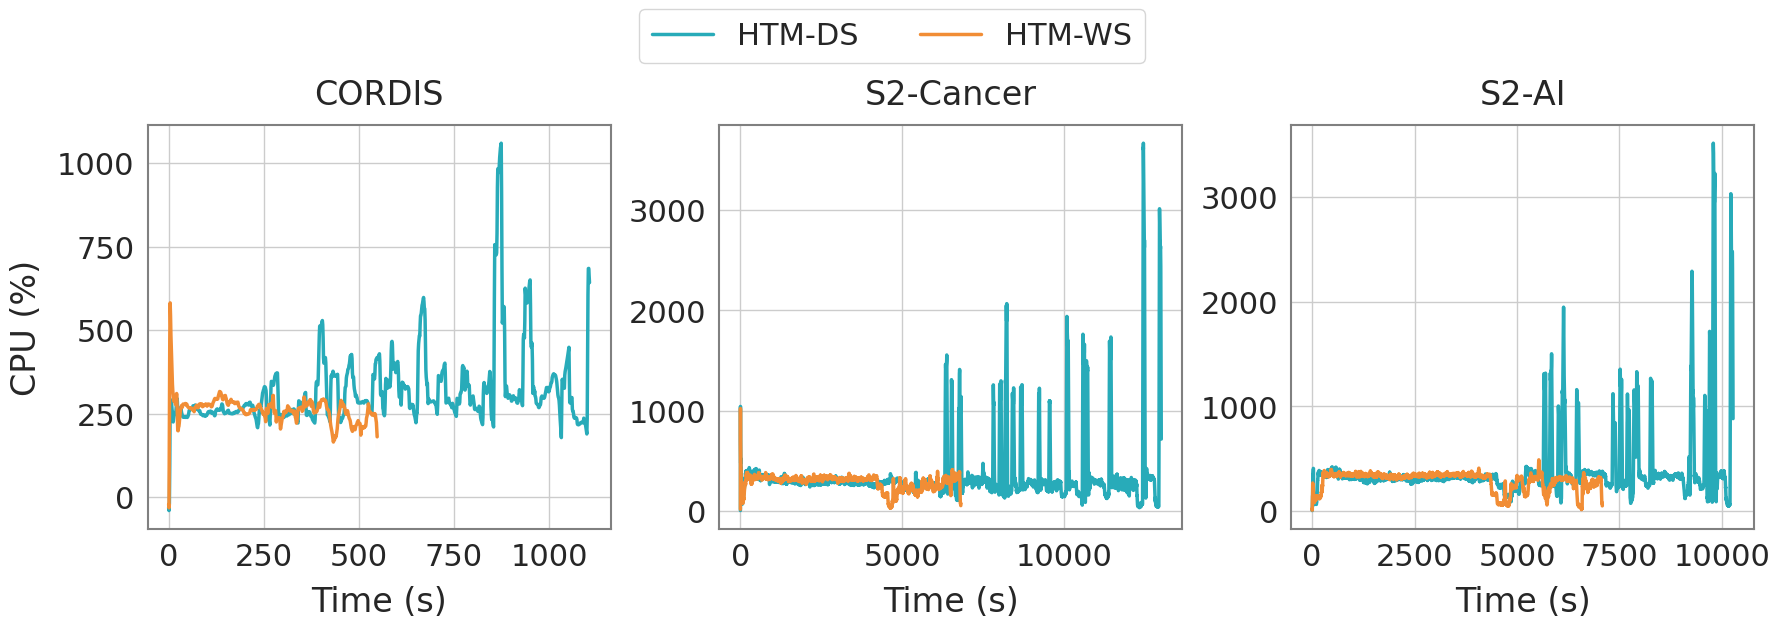

In [38]:
# Procesar los datos
# Diccionario para mapear nombres de archivos a nombres bonitos
algorithm_names = {
    "htm-ds": "HTM-DS",
    "htm-ws": "HTM-WS",
}
datset_names = {
    "cordis": "CORDIS",
    "cancer": "S2-Cancer",
    "s2cs-ai": "S2-AI"
}
# Procesar los datos
all_data = []
from collections import defaultdict
times = defaultdict(lambda: defaultdict(dict))
path_models = "/export/usuarios_ml4ds/lbartolome/Repos/my_repos/UserInLoopHTM/data/our_models"
algorithms = ["htm-ws", "htm-ds"]
datasets = ["cordis", "cancer", "s2cs-ai"]

for algo in algorithms:
    for dtset in datasets:
        exec_time_file = glob.glob(f"{path_models}/{algo}/{dtset}/execution_times.csv")
        if exec_time_file:
            execution_times = pd.read_csv(exec_time_file[0])
            execution_times = execution_times.rename(columns={"Execution Time (s)": "execution_time"})
        else:
            continue

        cpu_files = glob.glob(f"{path_models}/{algo}/{dtset}/cpu_usage_iter.*.csv")
        gpu_files = glob.glob(f"{path_models}/{algo}/{dtset}/gpu_usage_iter.*.csv")
        df_cpu, mean_time, std_time = load_and_truncate_cpu(cpu_files, "cpu", execution_times, filter_window, scale_factor=96)
        df_gpu, _, _ = load_and_truncate_gpu(gpu_files, "gpu", execution_times, filter_window, num_gpus=3)

        df_combined = pd.merge(df_cpu, df_gpu, on="time_instant", how="outer").fillna(0)
        df_combined["algorithm"] = algorithm_names[algo]  # Usar nombres formateados
        df_combined["dataset"] = dtset
        all_data.append(df_combined)

        times[algo][dtset] = {
            "mean_time": mean_time,
            "std_time": std_time,
        }

usage_data = pd.concat(all_data, ignore_index=True)
usage_data["gpu"] = 0.0 * len(usage_data)

times_df = pd.DataFrame([
    {"algorithm": algo, "dataset": ds, "mean_time": stats["mean_time"], "std_time": stats["std_time"]}
    for algo, datasets in times.items()
    for ds, stats in datasets.items()
])
times_df["algorithm"] = times_df["algorithm"].apply(lambda x: algorithm_names[x])

fig, axs = plt.subplots(1, len(datasets), figsize=(18, 6), sharex='col', sharey=False)  # Cambiar sharex a 'col'

for col, dataset in enumerate(datasets):
    subset = usage_data[usage_data["dataset"] == dataset]
    ax_cpu = axs[col]  # Solo eje para CPU

    for i, algo in enumerate(algorithm_names.values()):
        algo_data = subset[subset["algorithm"] == algo]
        algo_data_zoom = algo_data  # Filtra si quieres limitar el tiempo en eje X

        # CPU (línea sólida)
        sns.lineplot(
            data=algo_data_zoom, x="time_instant", y="cpu", ax=ax_cpu, 
            color=palette[i], linewidth=linewidth, label=algo if col == 0 else None
        )

    # Configurar etiquetas y título
    if col == 0:
        ax_cpu.set_ylabel("CPU (%)", fontsize=axis_label_size, labelpad=10)
    else:
        ax_cpu.set_ylabel("")

    if ax_cpu.get_legend() is not None:
        ax_cpu.get_legend().remove()

    ax_cpu.set_xlabel("Time (s)", fontsize=axis_label_size, labelpad=10)
    ax_cpu.set_title(f"{datset_names[dataset]}", fontsize=title_size, pad=15)
    ax_cpu.tick_params(axis='both', labelsize=tick_label_size)

# Leyenda global
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=4, fontsize=legend_size)

# Ajustes finales
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("images/revisions/cpu_usage_ours_with_ref.png", dpi=300, bbox_inches="tight")
plt.show()

In [39]:
times_df

,algorithm,dataset,mean_time,std_time
0,HTM-WS,cordis,8.627778,0.193426
1,HTM-WS,cancer,109.938889,8.726759
2,HTM-WS,s2cs-ai,110.944444,38.087315
3,HTM-DS,cordis,15.066667,8.718611
4,HTM-DS,cancer,188.911111,814.925926
5,HTM-DS,s2cs-ai,164.766667,31.975278


In [40]:
summary_table = usage_data.groupby(["algorithm", "dataset"]).agg(
    avg_cpu_usage=("cpu", "mean"),
    std_cpu_usage=("cpu", "std"),
    avg_gpu_usage=("gpu", "mean"),
    std_gpu_usage=("gpu", "std"),
).reset_index()

# combinar summary con tiempos
summary_table = pd.merge(
    summary_table,
    times_df,
    on=["algorithm", "dataset"],  
    how="inner"              
)

# Redondear valores
summary_table["avg_cpu_usage"] = summary_table["avg_cpu_usage"].round(1)
summary_table["std_cpu_usage"] = summary_table["std_cpu_usage"].round(1)
summary_table["avg_gpu_usage"] = summary_table["avg_gpu_usage"].round(1)
summary_table["std_gpu_usage"] = summary_table["std_gpu_usage"].round(1)
summary_table["mean_time"] = summary_table["mean_time"].round(1)
summary_table["std_time"] = summary_table["std_time"].round(1)

# Ordenar los datasets en el orden deseado
desired_order = ["cordis", "cancer", "s2cs-ai"]
summary_table["dataset"] = pd.Categorical(summary_table["dataset"], categories=desired_order, ordered=True)
summary_table = summary_table.sort_values("dataset")

# Crear columna combinada para CPU Usage con desviación estándar
summary_table["cpu_usage"] = summary_table.apply(
    lambda row: f"{row['avg_cpu_usage']} ± {row['std_cpu_usage']}", axis=1
)
summary_table["gpu_usage"] = summary_table.apply(
    lambda row: f"{row['avg_gpu_usage']} ± {row['std_gpu_usage']}", axis=1
)
summary_table["mean_time"] = summary_table.apply(
    lambda row: f"{row['mean_time']} ± {row['std_time']}", axis=1
)

# Reformatear la tabla manualmente
datasets = summary_table["dataset"].unique()
algorithms = summary_table["algorithm"].unique()

# Crear la tabla final
final_table = pd.DataFrame(index=algorithms)

for dataset in datasets:
    cpu_col = summary_table[summary_table["dataset"] == dataset].set_index("algorithm")["cpu_usage"]
    gpu_col = summary_table[summary_table["dataset"] == dataset].set_index("algorithm")["gpu_usage"]
    time_col = summary_table[summary_table["dataset"] == dataset].set_index("algorithm")["mean_time"]
    final_table[(dataset, "CPU Usage")] = cpu_col
    final_table[(dataset, "GPU Usage")] = gpu_col
    final_table[(dataset, "Time (min)")] = time_col

# Reconstruir el MultiIndex
final_table.columns = pd.MultiIndex.from_tuples(final_table.columns)

# Generar LaTeX manualmente con ajustes
latex_output = "\\begin{table}\n"
latex_output += "\\caption{Consumo total promedio de CPU con desviación estándar y tiempo de ejecución por modelo y dataset}\n"
latex_output += "\\label{tab:cpu_usage_with_std}\n"
latex_output += "\\centering\n"
latex_output += "\\resizebox{\\columnwidth}{!}{%\n"
latex_output += "\\begin{tabular}{llrlrlr}\n"
latex_output += "\\toprule\n"

# Añadir encabezados centrados
datasets_latex = " & ".join([f"\\multicolumn{{2}}{{c}}{{{dataset}}}" for dataset in datasets])
latex_output += f" & {datasets_latex} \\\\\n"

# Añadir líneas horizontales debajo de los encabezados
latex_output += "\\cmidrule(lr){2-3} \\cmidrule(lr){4-5} \\cmidrule(lr){6-7}\n"

# Añadir nombres de columnas secundarias
latex_output += " & CPU Usage & GPU Usage & Time (min)" * len(datasets) + " \\\\\n"
latex_output += "\\midrule\n"

# Añadir datos de la tabla
for algorithm in algorithms:
    row = final_table.loc[algorithm].values
    row_str = " & ".join([str(cell) for cell in row])
    latex_output += f"{algorithm} & {row_str} \\\\\n"

# Finalizar la tabla
latex_output += "\\bottomrule\n"
latex_output += "\\end{tabular}%\n"
latex_output += "}\n"
latex_output += "\\end{table}"

# Guardar en archivo
with open("cpu_usage_std_table.tex", "w") as f:
    f.write(latex_output)

# Mostrar en consola
print(latex_output)

\begin{table}
\caption{Consumo total promedio de CPU con desviación estándar y tiempo de ejecución por modelo y dataset}
\label{tab:cpu_usage_with_std}
\centering
\resizebox{\columnwidth}{!}{%
\begin{tabular}{llrlrlr}
\toprule
 & \multicolumn{2}{c}{cordis} & \multicolumn{2}{c}{cancer} & \multicolumn{2}{c}{s2cs-ai} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(lr){6-7}
 & CPU Usage & GPU Usage & Time (min) & CPU Usage & GPU Usage & Time (min) & CPU Usage & GPU Usage & Time (min) \\
\midrule
HTM-DS & 318.1 ± 115.2 & 0.0 ± 0.0 & 15.1 ± 8.7 & 360.6 ± 350.6 & 0.0 ± 0.0 & 188.9 ± 814.9 & 398.8 ± 352.3 & 0.0 ± 0.0 & 164.8 ± 32.0 \\
HTM-WS & 261.6 ± 41.4 & 0.0 ± 0.0 & 8.6 ± 0.2 & 288.5 ± 71.4 & 0.0 ± 0.0 & 109.9 ± 8.7 & 291.8 ± 85.5 & 0.0 ± 0.0 & 110.9 ± 38.1 \\
\bottomrule
\end{tabular}%
}
\end{table}


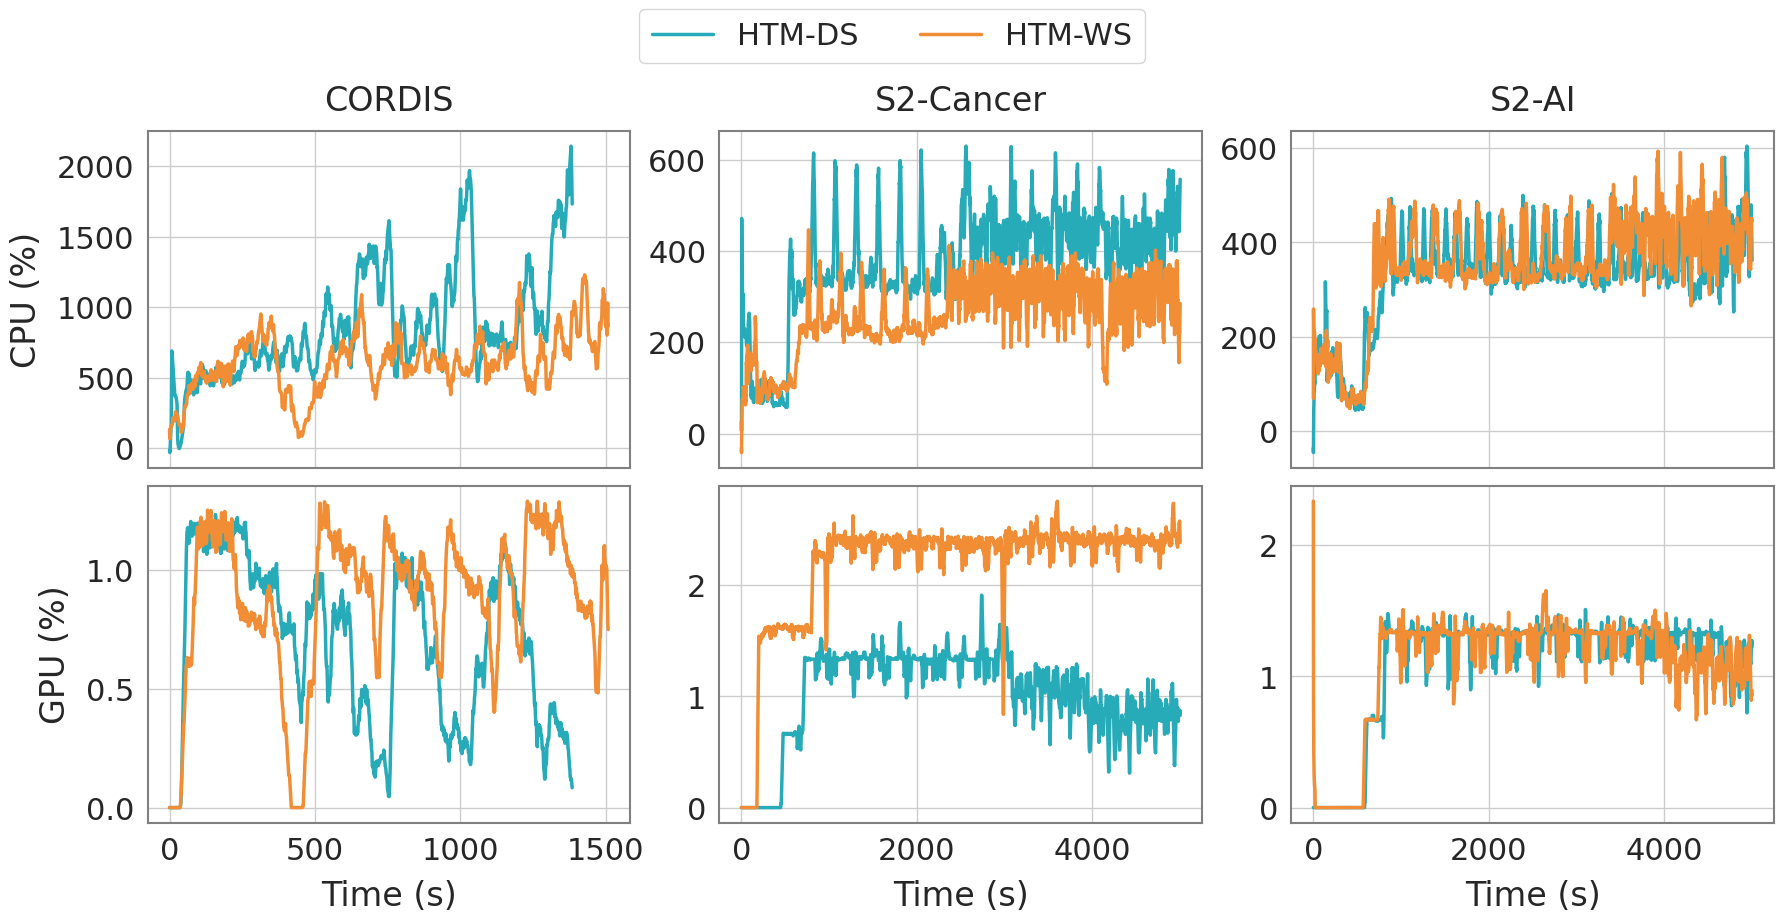

In [41]:
# Procesar los datos
# Diccionario para mapear nombres de archivos a nombres bonitos
algorithm_names = {
    "htm-ds": "HTM-DS",
    "htm-ws": "HTM-WS",
}
datset_names = {
    "cordis": "CORDIS",
    "cancer": "S2-Cancer",
    "s2cs-ai": "S2-AI"
}
# Procesar los datos
all_data = []
path_models = "/export/usuarios_ml4ds/lbartolome/Repos/my_repos/UserInLoopHTM/data/our_models_ctm"
algorithms = ["htm-ws", "htm-ds"]
datasets = ["cordis", "cancer", "s2cs-ai"]

for algo in algorithms:
    for dtset in datasets:
        exec_time_file = glob.glob(f"{path_models}/{algo}/{dtset}/execution_times.csv")
        if exec_time_file:
            execution_times = pd.read_csv(exec_time_file[0])
            execution_times = execution_times.rename(columns={"Execution Time (s)": "execution_time"})
        else:
            continue

        cpu_files = glob.glob(f"{path_models}/{algo}/{dtset}/cpu_usage_iter.*.csv")
        gpu_files = glob.glob(f"{path_models}/{algo}/{dtset}/gpu_usage_iter.*.csv")
        df_cpu, _,_ = load_and_truncate_cpu(cpu_files, "cpu", execution_times, filter_window, scale_factor=96)
        df_gpu,_,_ = load_and_truncate_gpu(gpu_files, "gpu", execution_times, filter_window, num_gpus=3)

        df_combined = pd.merge(df_cpu, df_gpu, on="time_instant", how="outer").fillna(0)
        df_combined["algorithm"] = algorithm_names[algo]  # Usar nombres formateados
        df_combined["dataset"] = dtset
        all_data.append(df_combined)

usage_data = pd.concat(all_data, ignore_index=True)

# Visualización mejorada
fig, axs = plt.subplots(2, len(datasets), figsize=(18, 9), sharex='col', sharey=False)  # Cambiar sharex a 'col'

for col, dataset in enumerate(datasets):
    subset = usage_data[usage_data["dataset"] == dataset]
    ax_cpu = axs[0, col]
    ax_gpu = axs[1, col]

    for i, algo in enumerate(algorithm_names.values()):
        algo_data = subset[subset["algorithm"] == algo]
        algo_data_zoom = algo_data[algo_data["time_instant"] <= 5000]
        
        # CPU (línea sólida)
        sns.lineplot(
            data=algo_data_zoom, x="time_instant", y="cpu", ax=ax_cpu, 
            color=palette[i], linewidth=linewidth, label=algo if col == 0 else None
        )
        
        # GPU (línea punteada) solo si el consumo no es 0
        if algo_data_zoom["gpu"].sum() > 0:  
            sns.lineplot(
                data=algo_data_zoom, x="time_instant", y="gpu", ax=ax_gpu, 
                color=palette[i], linewidth=linewidth, label=None
            )

    # Eliminar leyendas de los subgráficos
    if ax_cpu.get_legend() is not None:
        ax_cpu.get_legend().remove()
    if ax_gpu.get_legend() is not None:
        ax_gpu.get_legend().remove()

    # Mostrar etiquetas solo en la primera columna
    if col == 0:
        ax_cpu.set_ylabel("CPU (%)", fontsize=axis_label_size, labelpad=10)
        ax_gpu.set_ylabel("GPU (%)", fontsize=axis_label_size, labelpad=10)
    else:
        ax_cpu.set_ylabel("")
        ax_gpu.set_ylabel("")
    
    # Mostrar títulos solo en la primera fila
    if ax_cpu == axs[0, col]:
        ax_cpu.set_title(f"{datset_names[dataset]}", fontsize=title_size, pad=15)

    # Configuración del eje X
    ax_gpu.set_xlabel("Time (s)", fontsize=axis_label_size, labelpad=10)
    ax_cpu.tick_params(axis='both', labelsize=tick_label_size)
    ax_gpu.tick_params(axis='both', labelsize=tick_label_size)

# Leyenda global
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=4, fontsize=legend_size)

# Ajustes finales
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("images/revisions/cpu_usage_ours_ctm.png", dpi=300, bbox_inches="tight")
plt.show()